## Layers API

I'm going to re-build the model I built in `2017-10-15-football-cnn.ipynb` using TF's layers API following the outline of [this tutorial](https://www.tensorflow.org/tutorials/layers)

In [1]:
# Imports
import numpy as np
import tensorflow as tf
import scipy.ndimage
from scipy.misc import imsave
import matplotlib.pyplot as plt

%matplotlib inline

tf.logging.set_verbosity(tf.logging.INFO)

## Training Data

I have already generated my training data in the football-cnn notebook. The code below loads the data and coerces it into the expected format and shape for this tutorial

In [2]:
# NOTE: I changed this to utilize an SSD I have on this box. Should be: data/football/*.npy

train_x = np.load('data/serialized/train_x.npy')
train_y = np.load('data/serialized/train_y.npy')

test_x  = np.load('data/serialized/test_x.npy')
test_y  = np.load('data/serialized/test_y.npy')

In [3]:
# NOTE: the model expects only float 32?!?
train_x = train_x.astype(np.float32)
test_x  = test_x.astype(np.float32)

In [4]:
# This tutorial does one hot encoding a bit different than the last one.
# train_y labels are [x, y] when x == 1, the label is game
labels = [ label[0] for label in train_y ]
train_y = np.asarray(labels, dtype=np.int32)
print("count labels %s" % len(train_y))
print("Count game labels %s" % sum(train_y))
train_y

count labels 8000
Count game labels 4000


array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [5]:
labels = [ label[0] for label in test_y ]
test_y = np.asarray(labels, dtype=np.int32)
print("count labels %s" % len(test_y))
print("Count game labels %s" % sum(test_y))
test_y

count labels 2000
Count game labels 1000


array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [17]:
def football_model_fn(features, labels, mode):
    """Trains a model to predict if an image is a picture of a football game or not
    
    Graph:
    Follows from my previous, lower level, tutorial in 2017-10-15-football-cnn.ipynb
    conv1_1 => conv1_2 => pool1 => conv2_1 => conv2_2 => pool2 => connected => output
    """
    num_classes = 2
    keepRate1 = 1.
    keepRate2 = 1.
    alpha = 1e-3

    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 240, 320, 1])

    conv1_1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv1_1"
    )
    
    # Mine:
    # shape: [batch_size, 240, 320, 32]
    
    conv1_2 = tf.layers.conv2d(
        inputs=conv1_1,
        filters=32,
        kernel_size=[3,3],
        padding="same",
        activation=tf.nn.relu,
        name="conv1_2"
    )
    
    # Mine:
    # shape: [batch_size, 240, 320, 32]

     # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(
        inputs=conv1_2, 
        pool_size=[2, 2], 
        strides=[2, 2],
        padding="same",
        name="pool1"
    )
    
    pool1_1_drop = tf.layers.dropout(
        inputs=pool1,
        rate=(1 - keepRate1),
        name="pool1_1_drop"
    )
   
    # Tutorial:
    # Our output tensor produced by max_pooling2d() (pool1) has a shape of [batch_size, 14, 14, 32]: 
    # the 2x2 filter reduces width and height by 50% each.

    # Mine:
    # shape: [batch_size, 120, 160, 32]

    # Convolutional Layer #2 and Pooling Layer #2
    conv2_1 = tf.layers.conv2d(
        inputs=pool1_1_drop,
        filters=64,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.sigmoid,
        name="conv2_1"
    )
    
    conv2_2 = tf.layers.conv2d(
        inputs=conv2_1,
        filters=64,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv2_2"
    )
    
    pool2 = tf.layers.max_pooling2d(
        inputs=conv2_2,
        pool_size=[2, 2],
        strides=[2, 2],
        padding="same",
        name="pool2"
    )
    
    pool2_drop = tf.layers.dropout(
        inputs=pool2,
        rate=(1 - keepRate2),
        name="pool2_drop"
    )

    # Tutorial:
    # pool2 has shape [batch_size, 7, 7, 64] (50% reduction of width and height from conv2).

    # Mine:
    # shape: [batch_size, 60, 80, 64]

    # Fully Connected Layer

    pool2_flat = tf.reshape(pool2_drop, [-1, 60 * 80 * 64])

    fc1 = tf.layers.dense(
        inputs=pool2_flat,
        units=512,
        activation=tf.nn.relu,
        name="fc1"
    )
    
    dropout = tf.layers.dropout(
        inputs=fc1,
        rate=0.4,
        training=mode == tf.estimator.ModeKeys.TRAIN
    )

    # Tutorial:
    # Reduces 3136 (7 * 7 * 64) to 1024 in this dense layer

    # Mine:
    # Reduces 307200 (60 * 80 * 64) to 512 in this dense layer

    # Output Layer
    output = tf.layers.dense(
        inputs=dropout, 
        units=num_classes
    )

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=output, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(output, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=num_classes)
    
    loss = tf.losses.softmax_cross_entropy(
      onehot_labels=onehot_labels, logits=output)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=alpha)
        
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy"  : tf.metrics.accuracy(labels=labels, predictions=predictions["classes"]),
        "precision" : tf.metrics.precision(labels=labels, predictions=predictions["classes"]),
        "meaniou"   : tf.metrics.mean_iou(labels=labels, predictions=predictions["classes"], num_classes=num_classes),
        "auc"       : tf.metrics.auc(labels=labels, predictions=predictions["classes"]),
    }

    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [7]:
# NOTE: this mimick's the "__main__" function the tutorial is creating
# Create the Estimator
football_classifier = tf.estimator.Estimator(model_fn=football_model_fn,
                                             model_dir="/tmp/fball_convnet_model")

tensors_to_log = {"probabilities": "softmax_tensor"}
tensors_to_log = {}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log,
                                          every_n_iter=50 # 50
                             )
epochs   = 10
batch_sz = 100
step_cnt = (len(train_x) / batch_sz) * epochs

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_x},
    y=train_y,
    batch_size=batch_sz,
    num_epochs=None,
    shuffle=True)

football_classifier.train(
    input_fn=train_input_fn,
    steps=step_cnt,
    hooks=[logging_hook])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/fball_convnet_model', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/fball_convnet_model/model.ckpt.
INFO:tensorflow:
INFO:tensorflow:loss = 0.678032, step = 1
INFO:tensorflow:Saving checkpoints for 36 into /tmp/fball_convnet_model/model.ckpt.
INFO:tensorflow: (877.011 sec)
INFO:tensorflow:Saving checkpoints for 71 into /tmp/fball_convnet_model/model.ckpt.
INFO:tensorflow:global_step/sec: 0.0569984
INFO:tensorflow: (877.425 sec)
INFO:tensorflow:loss = 0.0193095, step = 101 (1754.435 sec)
INFO:tensorflow:Saving checkpoints for 106 into /tmp/fball_convnet_model/model.ckpt.
INFO:tensorflow:Saving checkpoints for 141 into 

In [18]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": test_x},
    y=test_y,
    num_epochs=1,
    shuffle=False)

eval_results = football_classifier.evaluate(input_fn=eval_input_fn)

print(eval_results)

INFO:tensorflow:Starting evaluation at 2017-10-22-23:56:59
INFO:tensorflow:Restoring parameters from /tmp/fball_convnet_model/model.ckpt-800
INFO:tensorflow:Finished evaluation at 2017-10-22-23:58:38
INFO:tensorflow:Saving dict for global step 800: accuracy = 0.967, global_step = 800, loss = 0.0986762, precision = 0.938086
{'accuracy': 0.96700001, 'loss': 0.098676227, 'precision': 0.93808633, 'global_step': 800}


INFO:tensorflow:Restoring parameters from /tmp/fball_convnet_model/model.ckpt-800
Not Game [98.0, 2.0]


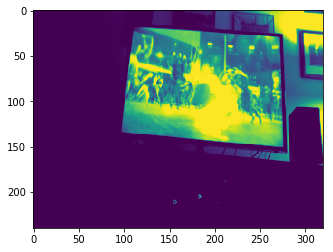

Not Game [97.0, 3.0]


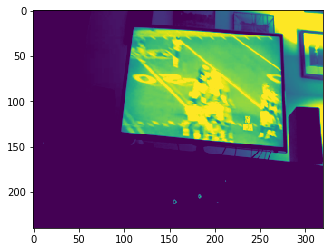

Game [2.0, 98.0]


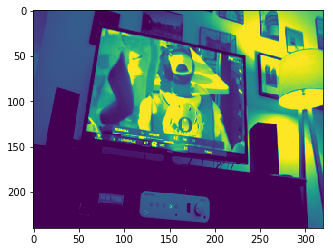

Not Game [94.0, 6.0]


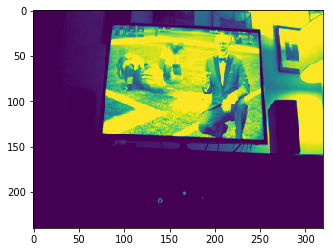

Game [3.0, 97.0]


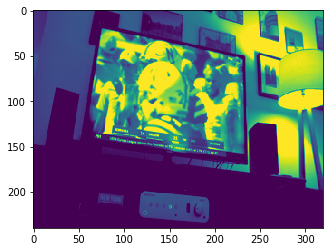

In [43]:
# Prediction:
# Evaluate the model and print results
predict_imgs = test_x[np.random.choice(range(len(test_x)), 5)]

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": predict_imgs},
    num_epochs=1,
    shuffle=False)

predict_results = football_classifier.predict(input_fn=predict_input_fn)

i = 0
for result in predict_results:
    res = ""
    res += "Game" if result['classes'] == 1 else "Not Game"
    print(res + " " + str([ round(prob * 100) for prob in result['probabilities']]))
    
    plt.imshow(predict_imgs[i].reshape(240, 320))
    plt.show()
    i = i + 1

In [42]:
feature_spec = {'x': tf.FixedLenFeature([240, 320, 1], np.float32), }

def serving_input_receiver_fn():
    """An input receiver that expects a serialized tf.Example."""
    serialized_tf_example = tf.placeholder(dtype=tf.string,
                                         shape=[2],
                                         name='input_example_tensor')
    receiver_tensors = {'examples': serialized_tf_example}
    features = tf.parse_example(serialized_tf_example, feature_spec)
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

football_classifier.export_savedmodel("/tmp/foo", serving_input_receiver_fn)

ValueError: export_outputs must be a dict.